# CS-502 Homework 2: Graph Neural Networks

Author: Mika Senghaas (mika.senghaas@epfl.ch)

This homework assignment implements a custom **graph neural network** (GNN) in pure [Pytorch](https://pytorch.org) and perform experiments on the [MUTAG]() dataset for graph classficiation of chemcical compounds. MUTAG consists of a collection of chemcical compounds, each represented as a graph. Here, *nodes* are atoms and identified by the atom type, *edges* are chemical bounds between the atoms with features indicating the chemical bond type. Each graph represents a chemical compound and is labelled as either *mutagenic* (positive) or *non-mutagenic* (negative) class. 

This notebook implements a graph neural network, which will be used in experiments to build a high-quality binary classifier for the mutagenicitiy of a chemical compound.

## Imports & Setup

We import the necessary modules and set global parameters. Note, that this notebook was run in the lastest minor release of Python `3.9`.

In [1]:
# Standard library
import os
import sys
import time
import uuid
import json
import random
from itertools import product

# External libraries
import pandas as pd
import networkx as nx
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
print(sys.version)

3.9.16 (main, Dec 16 2022, 22:25:05) 
[Clang 14.0.0 (clang-1400.0.29.202)]


In [3]:
# Global variables
BASE_PATH = os.getcwd()
DATA_PATH = os.path.join(BASE_PATH, 'data', 'mutag.jsonl')

# Flag to train the model
TRAIN = False

# Check if data exists and is in the right place
assert os.path.exists(DATA_PATH), f'❌ Error: Please download the data and place it in {DATA_PATH}'

In [4]:
# Set seed for reproducibility
random.seed(1)
torch.manual_seed(1)

# Set plot styles
sns.set_style("darkgrid")

# Set float precision for pandas
pd.set_option("display.precision", 2)

# Test data
test_x = torch.eye(3)
test_adj = torch.randint(0, 2, (3, 3)).float()
test_e = torch.randint(0, 2, (3, 3, 4)).float()

In [5]:
class Meta(type):
    def __repr__(cls):
        return cls.__name__

## Part 1: Implementing Different Graph Convolution and Pooling Layers

---

### Normal Convolution (Graph Convolution)

A regular graph convolution in the $l$-th layer computes the embedding of the $v$-th node, $\mathbf{h}_v$ through

$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \sum_{u\in N(v)} \frac{\mathbf{h}_u^{(l)}}{|N(v)|} + \mathbf{B}_l \mathbf{h}_v^{(l)} \right).
$$

Note, that here $\sigma$ is a non-linearity, $\mathbf{W}_l$ and $\mathbf{B}_l$ are both trainable weight matrices with dimension 
$\text{in\_features} \times \text{out\_features}$ and $N(v)$ is the set of adjacent nodes in the graph.

We can represent the average over the neighbourhood of node $v$ through a matrix product of the adjacency matrix $\mathbf{A}$ with the matrix $\mathbf{H}^{(l)}=\left[\mathbf{h}^{(l)}_1, ..., \mathbf{h}^{(l)}_{|V|}\right]$ holding all node embeddings in the $l$ layer (corrected by the inverse of the degree $\tilde{A}$ to obtain an average) as

$$
H^{(l+1)} = \sigma\left( \tilde{A}H^{(l)}W_l^\top + H^{(l)}B_l^\top \right).
$$

In [6]:
class GraphConv(nn.Module, metaclass=Meta):
    """Basic graph convolutional layer implementing the simple neighborhood aggregation."""

    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the graph convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        
        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layers
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Linear(in_features, out_features, bias=False)

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Neighbourhood aggregation
        adj = adj / adj.sum(1, keepdim=True).clamp(1)
        x_agg = adj @ x

        # Graph convolution
        x = self.weight(x_agg) + self.bias(x)

        # Apply non-linear activation if specified
        if self.activation:
            return self.activation(x)
        return x

In [7]:
# Test graph convolution
conv = GraphConv(3, 2)
out = conv(test_x, test_adj)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(GraphConv) == "GraphConv", f"Class name should be `GraphConv`, but is {repr(GraphConv)}"

print("Tests passed. ✅")

Tests passed. ✅


### GraphSAGE (Customised Aggregation)

GraphSAGE is a generalised version of the regular graph convolution, in which any type of aggregation can be applied to. Instead of adding the result of two matrix products and performing a non-linearity, here the original node embeddings are concatenated with the aggregated neighbourhood embeddings and then linearly transformed. The equation for the GraphSAGE layer is:

$$
\mathbf{h}_v^{(l+1)} = \sigma\left( \mathbf{W}_l \cdot \mathrm{CONCAT} \left[\mathbf{h}_v^{(l)}, \mathrm{AGG} \left(\left\{\mathbf{h}_u^{(l)}, \forall u\in N(v) \right\}\right) \right] \right),
$$

where $v$ index the node, $l$ the layer, $\mathbf{h}$ are the node embeddings, $\sigma$ is a non-linearity, $N(v)$ is the set of neighbor of node $v$, and $\mathbf{W}$ is the trainable weight matrix of the layer. $\mathrm{CONCAT}$ is the concatenation operation, while $\mathrm{AGG}$ is an arbitrary aggregation function.

In [8]:
# Aggregations
class MeanAggregation(nn.Module):
    """Aggregate node features by averaging over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        x_agg = adj / adj.sum(1, keepdim=True).clamp(1)

        return x_agg @ x
    
class SumAggregation(nn.Module):
    """Aggregate node features by summing over the neighborhood."""
    def __init__(self):
        super().__init__()

    def forward(self, x, adj):
        return adj @ x

In [9]:
class GraphSAGEConv(nn.Module, metaclass=Meta):
    """GraphSAGE convolutional layer."""
    
    def __init__(self, 
        in_features, 
        out_features, 
        aggregation=SumAggregation,
        activation=None):
        """
        Initialize the GraphSAGE convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            aggregation (nn.Module or callable): aggregation function to apply, as x_agg = aggegration(x, adj).
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layer (no bias)
        self.weight = nn.Linear(2*in_features, out_features, bias=False)

        # Aggregation function
        self.aggregation = aggregation()

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (batch_dim, num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """
        # Neighbourhood aggregation
        x_agg = self.aggregation(x, adj)

        # Concatenate node features and aggregated features
        x_cat = torch.cat([x, x_agg], dim=1)
        
        # Apply linear transformation
        x = self.weight(x_cat)

        # Apply non-linear activation if specified
        if self.activation:
            return self.activation(x)
        return x

In [10]:
# Test GraphSAGE
conv = GraphSAGEConv(3, 2)
out = conv(test_x, test_adj)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(GraphSAGEConv) == "GraphSAGEConv", f"Class name should be `GraphSAGEConv`, but is {repr(GraphSAGEConv)}"

print("Tests passed. ✅")

Tests passed. ✅


### Attention-based Convolution



In [11]:
class AttentionGraphConvolution(nn.Module, metaclass=Meta):
    """Attention-based convolutional layer."""
    
    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the attention-based convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()

        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layer (no bias)
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.att = nn.Linear(2*out_features, 1, bias=False)

        # Non-linear activation function (optional)
        self.leaky_relu = nn.LeakyReLU()
        self.softmax = nn.Softmax(dim=1)
        self.activation = activation

    def forward(self, x, adj):
        """
        Perform an attention-based graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """

        # Linear transformation 
        x = self.weight(x)

        # Add self-loops to the adjacency matrix
        adj = torch.minimum(
            adj + torch.eye(adj.shape[0]), 
            torch.ones_like(adj))

        # Attention weights
        v = len(adj)
        u_indices = torch.cat([
            torch.fill(torch.empty(v), i).long() 
            for i in torch.arange(v)])
        v_indices = torch.arange(v).repeat(v)

        cc = torch.cat([x[u_indices], x[v_indices]], dim=1)
        att = self.leaky_relu(self.att(cc).reshape(v, v))

        # Normalise attention weights via softmax on neighbours
        adj_mask = torch.where(adj > 0, torch.zeros_like(adj), torch.full_like(adj, -torch.inf))
        att = att + adj_mask
        att = self.softmax(att)

        # Attention-based aggregation
        x = att @ x
        
        # Apply non-linear activation if specified 
        if self.activation:
            return self.activation(x)
        return x

In [12]:
# Test attention-based convolution
conv = AttentionGraphConvolution(3, 2)
out = conv(test_x, test_adj)

assert out.shape == (3,2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(AttentionGraphConvolution) == "AttentionGraphConvolution", f"Class name should be `AttentionGraphConvolution`, but is {repr(AttentionGraphConvolution)}"

print(f"Tests passed. ✅")

Tests passed. ✅


### Mean Pooling

Mean pooling computes a graph level representation $\mathbf{h}_{\text{global}}$ as the mean (average) of all node features

$$
\textbf{h}_{\text{global}} = \frac{1}{N} \sum_{i=1}^N \mathbf{X}_i,
$$

where $\mathbf{X} \in \mathbb{R}^{N \times D}$ where $N$ is the number of nodes and $D$ is the feature dimension. Finally, $\mathbf{X}_i$ is node representation of the $i$-th node.

In [13]:
class MeanPooling(nn.Module, metaclass=Meta):
    """Mean pooling layer."""

    def __init__(self):
        """Initialize mean pooling layer."""
        super().__init__()

    def forward(self, x):
        """
        Computes the average of all node features.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).

        Returns:
            Tensor: Aggregated node features of shape (in_features).
        """
        return torch.mean(x, dim=0)

In [14]:
# Simple test
x = torch.arange(12).reshape(4, 3).float()
maxpool = MeanPooling()
out = maxpool(x)

assert out.shape == (3,), "Output shape should be (3, ), but is {out.shape}"
assert torch.equal(out, torch.Tensor([4.5, 5.5, 6.5])), f"Output should be torch.Tensor([9, 10, 11]), but is {out}"
assert repr(MeanPooling) == "MeanPooling", f"Class name should be MaxPooling, but is {repr(MeanPooling)}"

print("Tests passed. ✅")

Tests passed. ✅


### Max Pooling

Max pooling computes a graph level representation $\mathbf{h}_{\text{global}}$ by taking the maximum value from each feature dimension across all nodes in the graph-level representation

$$
\textbf{h}_{\text{global}, d} =  \max_{i=1}^N \mathbf{X}_{i, d}
$$

for each feature dimension $d$ and again $\mathbf{X} \in \mathbb{R}^{N \times D}$ where $N$ is the number of nodes and $D$ is the feature dimension and $\mathbf{X}_i$ is node representation of the $i$-th node.

In [15]:
class MaxPooling(nn.Module, metaclass=Meta):
    """Max pooling layer."""

    def __init__(self):
        """Initialize mean pooling layer."""
        super().__init__()

    def forward(self, x):
        """
        Computes the max pool of all node features.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).

        Returns:
            Tensor: Max pooled node features of shape (in_features,).
        """

        return torch.max(x, dim=0).values

In [16]:
# Simple test
x = torch.arange(12).reshape(4, 3)
maxpool = MaxPooling()
out = maxpool(x)

assert out.shape == (3,), f"Output shape should be (3,), but is {out.shape}"
assert torch.equal(out, torch.arange(9, 12)), f"Output should be torch.Tensor([9, 10, 11]), but is {out}"
assert repr(MaxPooling) == "MaxPooling", f"Class name should be MaxPooling, but is {repr(MaxPooling)}"

print("Tests passed. ✅")

Tests passed. ✅


## Part 2: Custom Network Design with Node Features

---

### Custom Network Architecture

This is a generic graph neural network for binary graph classification. It can be composed of the modules from above that can through user parameters for the number of node features as input, type and number of graph convolutional layers, pooling mechanism, dropout and batch normalisation.

In [17]:
class GNN(nn.Module):
    """Custom graph neural network model for binary graph prediction."""

    def __init__(self, 
        num_features: int, 
        conv_dims: list[int], 
        conv: nn.Module = GraphConv, 
        pooling: nn.Module = MeanPooling, 
        activation: nn.Module or callable = nn.LeakyReLU, 
        dropout=0.,
        ):
        """
        Initialize the GNN model for graph prediction.

        Args:
            num_features (int): Number of input node features.
            conv_dims (list of int): Number of hidden features in each graph convolution layers.
            activation (nn.Module or callable): Activation function to apply.
            dropout (float): Dropout probability. (optional)
        """
        super().__init__()

        # Create UUID
        self.uuid = uuid.uuid4().hex
        
        # Save parameters
        self.dropout = dropout

        # Compute dimensions and activations for graph conv layers
        dimensions = [num_features] + conv_dims
        in_dimensions = dimensions[:-1]
        out_dimensions = dimensions[1:]
        activations = [activation] * (len(conv_dims) - 1) + [None]

        # Create Graph convolution layers
        self.convs = nn.ModuleList([
            conv(
                in_features, 
                out_features,
                activation=activation() if activation else activation
            ) for in_features, out_features, activation in 
            zip(in_dimensions, out_dimensions, activations)
        ])

        """
        # Batch norm layers
        self.norms = nn.ModuleList()
        for dim in conv_dims:
            self.norms.append(nn.BatchNorm1d(dim))
        """
        
        # Pooling layer
        self.pooling = pooling()

        # Fully connected layer
        self.fc = nn.Linear(conv_dims[-1] if conv_dims else num_features, 1)


    def forward(self, x, adj):
        """
        Perform forward pass for graph prediction.

        Args:
            x (Tensor): Input node features of shape (num_nodes, num_features).
            adj (Tensor): Adjacency matrix of the graph, typically sparse, shape (num_nodes, num_nodes).
        """

        # Graph convolution layers
        for conv in self.convs:
            x = F.dropout(conv(x, adj), p=self.dropout)

        # Pooling layer
        x = self.pooling(x)

        # Fully connected layer
        x = self.fc(x)

        return x

In [18]:
# Test architecture
model = GNN(3, [4, 4])
logits = model(test_x, test_adj)

assert logits.shape == (1,), f"Expected shape (1,), but got {logits.shape}"
print("Tests passed. ✅")

Tests passed. ✅


### Data Loading and Partitioning

This section loads and partitions the input data using the utility classes `torch.utils.data.Dataset` and `torch.utils.data.RandomDataSampler` to create random (but seeded) partitioning into training (70%), validation (15%) and testing (15%).

In [19]:
# Load the dataset
class MUTAGDataset(Dataset):
    def __init__(self, datapath: str):
        super().__init__()

        with open(datapath, "r") as f:
            raw = f.read()
        
        self.graphs = [json.loads(line) for line in raw.splitlines()]

    def __len__(self):
        """
        Returns the number of graphs in the dataset
        """
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Returns a single graph's node features, edge features, adjacency matrix and label

        Args:
            idx (int): Index of the graph to return.

        Returns:
            Tensor: Node features of shape (num_nodes, num_features).
            Tensor: Adjacency matrix of shape (num_nodes, num_nodes).
        """
        graph = self.graphs[idx]

        # Create adjacency matrix
        n = graph["num_nodes"]
        adj = torch.zeros((n, n))
        d_edges = len(graph["edge_attr"][0])
        edge_attr = torch.zeros((n, n, d_edges))
        for idx, (i, j) in enumerate(zip(graph["edge_index"][0], graph["edge_index"][1])):
            adj[i, j] = 1
            adj[j, i] = 1
            edge_attr[i, j] = torch.Tensor(graph["edge_attr"][idx])
            edge_attr[j, i] = torch.Tensor(graph["edge_attr"][idx])

        node_feat = torch.Tensor(graph["node_feat"])
        label = torch.Tensor(graph["y"])

        return node_feat, edge_attr, adj, label

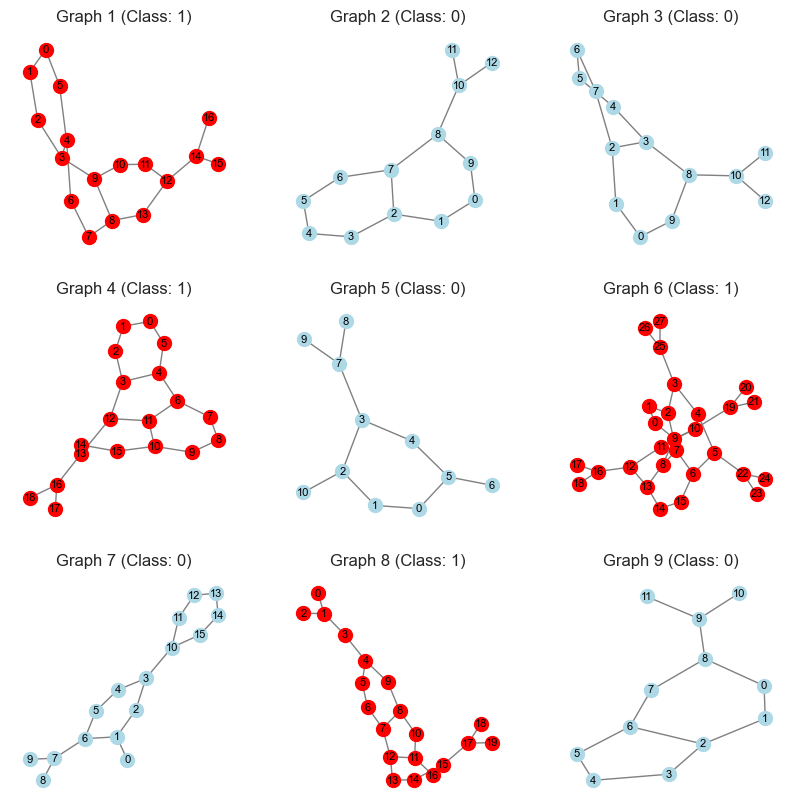

In [20]:
# Test dataset class
data = MUTAGDataset(datapath=DATA_PATH)
node_feat, edge_attr, adj, label = data[0]

assert len(node_feat) == len(adj), f"Expected 17 nodes, but got {len(node_feat)}"

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
colors = ["lightblue", "red"]
styles = {
    "node_size": 100,
    "edge_color": "grey",
    "with_labels": True,
    "font_size": 8,
}
for i in range(9):
    _, _, adj, label = data[i]
    G = nx.from_numpy_array(adj.numpy())
    nx.draw(G, pos=nx.spring_layout(G), ax=ax[i//3, i%3],  node_color=colors[int(label.item())], **styles)
    ax[i//3, i%3].set_title(f"Graph {i+1} (Class: {int(label.item())})")

In [21]:
# Data splitting
n_val = int(0.15 * len(data))
n_test = int(0.15 * len(data))
n_train = len(data) - n_val - n_test
split_num_samples = [n_train, n_val, n_test]

# Split dataset randomly
train_data, val_data, test_data = random_split(data, split_num_samples)

In [22]:
# Quick EDA
print(f"Number of Training Graphs: {len(train_data)}")
print(f"Number of Validation Graphs: {len(val_data)}")
print(f"Number of Test Graphs: {len(test_data)}")

def compute_class_distribution(data):
    _, dist = torch.unique(torch.stack([label for _, _, _, label in data]), return_counts=True)
    return dist

def compute_pos_ratio(dist):
    return dist[1] / sum(dist)

# Compute class distribution
train_class_dist = compute_class_distribution(train_data)
val_class_dist = compute_class_distribution(val_data)
test_class_dist = compute_class_distribution(test_data)

# Compute positive weight (for binary cross entropy loss)
train_ratio = compute_pos_ratio(train_class_dist)
val_ratio = compute_pos_ratio(val_class_dist)
test_ratio = compute_pos_ratio(test_class_dist)

print(f"\nP/N Training Graphs: {train_class_dist} (Ratio: {train_ratio:.2f})")
print(f"P/N Validation Graphs: {val_class_dist} (Ratio: {val_ratio:.2f})")
print(f"P/N Test Graphs: {test_class_dist} (Ratio: {test_ratio:.2f})")

Number of Training Graphs: 132
Number of Validation Graphs: 28
Number of Test Graphs: 28

P/N Training Graphs: tensor([45, 87]) (Ratio: 0.66)
P/N Validation Graphs: tensor([ 5, 23]) (Ratio: 0.82)
P/N Test Graphs: tensor([13, 15]) (Ratio: 0.54)


In [23]:
# Create data loaders
batch_size = 1
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Hyperparameter Tuning

This section trains graph neural networks in different configurations (hyperparameters). To do so, we first define a set of utility functions for building a hyper-parameter grid, cross-validated training, and visualising the training.

In [24]:
def validate(model, data_loader, criterion, use_edges=False, verbose=False):
    """
    Test model on data split using common classification accuracy.

    Args:
        model (nn.Module): Model to be tested.
        data_loader (DataLoader): Data loader containing the data.
        criterion (nn.Module): Loss function to use.
        use_edges (boolean): Whether to use edge features or not.
        verbose (boolean): Whether to print classification report or not. (optional)

    Returns:
        dict: Dictionary containing the model's performance on the data.
    """
    model.eval()

    loss = 0.
    all_preds, all_targets = [], []
    for batch in data_loader:
        # Extract node features, edge features, adjacency matrix and labels
        node_feats, edges, adjs, labels = batch

        # Forward pass
        neighs = edges if use_edges else adjs
        logits = model(node_feats.squeeze(), neighs.squeeze())
        probs = F.sigmoid(logits)
        preds = probs.round()

        # Compute loss
        batch_loss = criterion(logits, labels.reshape(-1))
        loss += batch_loss.item()

        # Save predictions and targets for later
        all_preds.append(preds.item())
        all_targets.append(labels.item())

    # Compute classification metrics
    loss /= len(data_loader)
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, zero_division=0., average="macro")
    recall = recall_score(all_targets, all_preds, zero_division=0., average="macro")
    precision = precision_score(all_targets, all_preds, zero_division=0., average="macro")
    conf_matrix = confusion_matrix(all_targets, all_preds)

    # Print classification report (if verbose flag is set)
    if verbose:
        test_classification_report = classification_report(all_targets, all_preds, zero_division=0.)
        print(test_classification_report)

    return {
        "loss": loss,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": conf_matrix,
    }

In [25]:
def train_epoch(model, data_loader, criterion, optimiser, use_edges=False):
    """
    Train model on training data using specified loss function and optimiser.

    Args:
        model (nn.Module): Model to be tested.
        data_loader (DataLoader): Data loader containing the training data.
        criterion (nn.Module): Loss function to be optimized.
        optimiser (nn.optim.Optimizer): Optimiser to use for training.
        use_edges (boolean): Whether to use edge features or not.

    Returns:
        tuple: Tuple containing the training loss and accuracy.
    """

    # Set model into training mode
    model.train()

    train_loss, train_acc = 0., 0.
    for batch in data_loader:
        optimiser.zero_grad()

        # Extract data features
        node_feats, edges, adjs, labels = batch

        # Forward pass
        neighs = edges if use_edges else adjs
        logits = model(node_feats.squeeze(), neighs.squeeze())
        probs = F.sigmoid(logits)
        preds = probs.round()

        # Compute loss value and update weights
        batch_loss = criterion(logits, labels.reshape(-1))
        batch_loss.backward()
        optimiser.step()

        # Compute batch accuracy
        batch_acc = (preds == labels).float().mean()

        # Update training loss and accuracy
        train_loss += batch_loss.item()
        train_acc += batch_acc.item()

    # Normalise training loss and acc
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc

In [26]:
# Training loop
def train(model, train_loader, val_loader, criterion, optimiser, epochs, use_edges=False, verbose=2):
    """
    Train model on training data using specified loss function and optimiser.

    Args:
        model (nn.Module): Model to be tested.
        train_loader (DataLoader): Data loader containing the trainin data.
        val_loader (DataLoader): Data loader containing the trainin data.
        criterion (nn.Module): Loss function to be optimized.
        optimiser (nn.optim.Optimizer): Optimiser to use for training.
        epochs (int): Number of epochs to train for.
        use_edges (boolean): Whether to use edge features or not.
        verbose (int): 0 for no output, 1 for tqdm progress, 2 for batch summaries. (optional)

    Returns:
        results (dict): Dictionary containing the model's final performance on the data training and validation data and history of loss and accuracy on both splits.
    """
    
    # Initialise training loss and accuracy
    metrics = ["train_loss", "train_acc", "val_loss", "val_acc"]
    history = {metric: [] for metric in metrics}
    pbar = tqdm(range(epochs), disable=verbose != 1)
    for epoch in pbar:
        # Train model
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimiser, use_edges=use_edges)

        # Validate model
        val_results = validate(model, val_loader, criterion, use_edges=use_edges)
        val_loss = val_results["loss"]
        val_acc = val_results["accuracy"]

        # Save training/ validation loss and accuracy
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        progress= " | ".join([
            f"{epoch+1}/{epochs}",
            f"Train {train_loss:.4f} ({(100*train_acc):.1f}%)",
            f"Val {val_loss:.4f} ({(100*val_acc):.1f}%)"
        ])

        # Verbose output
        if verbose == 1:
            pbar.set_description(progress)
        elif verbose == 2:
            print(progress)

    results = {
        "train_results": {
            "loss": history["train_loss"][-1], 
            "accuracy": history["train_acc"][-1]},
        "val_results": val_results,
        "history": history,
    }

    return results

In [27]:
def plot_training_history(train_results):
    """
    Plots the training and validation loss (left subplot) and accuracy (right subplot) over the training epochs saved in the history dictionary.

    Args:
        history (dict): Dictionary containing the training and validation loss and accuracy.

    Returns:
        fig (matplotlib.pyplot.figure): Figure containing the training history plots (can be used for saving the figure)
    """
    
    # Create figure with two subplots
    fig, axs  = plt.subplots(1, 2, figsize=(12, 4))

    # Extract history of train/val loss and accuracy
    history = train_results["history"]

    # Plot train/val loss and accuracy
    sns.lineplot(history["train_loss"], label="Train Loss", ax=axs[0])
    sns.lineplot(history["val_loss"], label="Val Loss", ax=axs[0])
    sns.lineplot(history["train_acc"], label="Train Acc", ax=axs[1])
    sns.lineplot(history["val_acc"], label="Val Acc", ax=axs[1])

    # Set plot labels
    for ax in axs:
        ax.set_xlabel("Epoch")
        ax.legend()
    axs[0].set_ylabel("Loss")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim(0, 1)

    return fig

In [28]:
def build_grid(hyperparams):
    """
    Builds a grid of hyperparameters to be tested.

    Args:
        hyperparams (dict): Dictionary of hyperparameters and their values and an iterable of values to test.

    Returns:
        list[dict]: List of hyperparameter combinations to test, each as dictionary of hyperparameter names and value. Length is the product of the number of values for each hyperparameter.
    """
    return [dict(zip(hyperparams.keys(), values)) for values in product(*hyperparams.values())]

In [29]:
# Custom activation functions
class LeakyReLU(nn.LeakyReLU, metaclass=Meta):
    def __init__(self):
        super().__init__()

In [30]:
model_hyperparams = {
    "num_features": [7],
    "conv_dims": [[5, 5, 5], [256, 128, 64]],
    "conv": [GraphConv, GraphSAGEConv, AttentionGraphConvolution],
    "pooling": [MeanPooling, MaxPooling],
    "activation": [LeakyReLU],
    "dropout": [.0],
}

model_hyperparams_grid = build_grid(model_hyperparams)
num_models_to_test = len(model_hyperparams_grid)

print(f"Testing {len(model_hyperparams_grid)} model configurations")

Testing 12 model configurations



Model [1/12]
num_features              7
conv_dims         [5, 5, 5]
conv              GraphConv
pooling         MeanPooling
activation        LeakyReLU
dropout                 0.0
dtype: object


100/100 | Train 0.3558 (81.8%) | Val 0.3405 (75.0%): 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Training complete. ✅ (18.6s)

Model [2/12]
num_features             7
conv_dims        [5, 5, 5]
conv             GraphConv
pooling         MaxPooling
activation       LeakyReLU
dropout                0.0
dtype: object


100/100 | Train 0.3574 (84.1%) | Val 0.4562 (78.6%): 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Training complete. ✅ (18.6s)

Model [3/12]
num_features                7
conv_dims           [5, 5, 5]
conv            GraphSAGEConv
pooling           MeanPooling
activation          LeakyReLU
dropout                   0.0
dtype: object


100/100 | Train 0.1993 (87.9%) | Val 0.3155 (82.1%): 100%|██████████| 100/100 [00:16<00:00,  6.07it/s]


Training complete. ✅ (16.5s)

Model [4/12]
num_features                7
conv_dims           [5, 5, 5]
conv            GraphSAGEConv
pooling            MaxPooling
activation          LeakyReLU
dropout                   0.0
dtype: object


100/100 | Train 0.1770 (90.9%) | Val 0.3729 (85.7%): 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


Training complete. ✅ (16.9s)

Model [5/12]
num_features                            7
conv_dims                       [5, 5, 5]
conv            AttentionGraphConvolution
pooling                       MeanPooling
activation                      LeakyReLU
dropout                               0.0
dtype: object


100/100 | Train 0.3949 (79.5%) | Val 0.3918 (75.0%): 100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


Training complete. ✅ (26.7s)

Model [6/12]
num_features                            7
conv_dims                       [5, 5, 5]
conv            AttentionGraphConvolution
pooling                        MaxPooling
activation                      LeakyReLU
dropout                               0.0
dtype: object


100/100 | Train 0.4107 (77.3%) | Val 0.4103 (82.1%): 100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


Training complete. ✅ (27.3s)

Model [7/12]
num_features                 7
conv_dims       [256, 128, 64]
conv                 GraphConv
pooling            MeanPooling
activation           LeakyReLU
dropout                    0.0
dtype: object


100/100 | Train 0.6247 (75.0%) | Val 0.3694 (78.6%): 100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Training complete. ✅ (23.7s)

Model [8/12]
num_features                 7
conv_dims       [256, 128, 64]
conv                 GraphConv
pooling             MaxPooling
activation           LeakyReLU
dropout                    0.0
dtype: object


100/100 | Train 0.3755 (84.1%) | Val 0.4224 (82.1%): 100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Training complete. ✅ (25.5s)

Model [9/12]
num_features                 7
conv_dims       [256, 128, 64]
conv             GraphSAGEConv
pooling            MeanPooling
activation           LeakyReLU
dropout                    0.0
dtype: object


100/100 | Train 0.2283 (88.6%) | Val 0.3736 (82.1%): 100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


Training complete. ✅ (22.5s)

Model [10/12]
num_features                 7
conv_dims       [256, 128, 64]
conv             GraphSAGEConv
pooling             MaxPooling
activation           LeakyReLU
dropout                    0.0
dtype: object


100/100 | Train 0.2736 (87.1%) | Val 0.4268 (85.7%): 100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


Training complete. ✅ (23.7s)

Model [11/12]
num_features                            7
conv_dims                  [256, 128, 64]
conv            AttentionGraphConvolution
pooling                       MeanPooling
activation                      LeakyReLU
dropout                               0.0
dtype: object


100/100 | Train 0.4340 (74.2%) | Val 0.3900 (75.0%): 100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


Training complete. ✅ (50.0s)

Model [12/12]
num_features                            7
conv_dims                  [256, 128, 64]
conv            AttentionGraphConvolution
pooling                        MaxPooling
activation                      LeakyReLU
dropout                               0.0
dtype: object


100/100 | Train 0.5733 (71.2%) | Val 0.4332 (78.6%): 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Training complete. ✅ (52.7s)


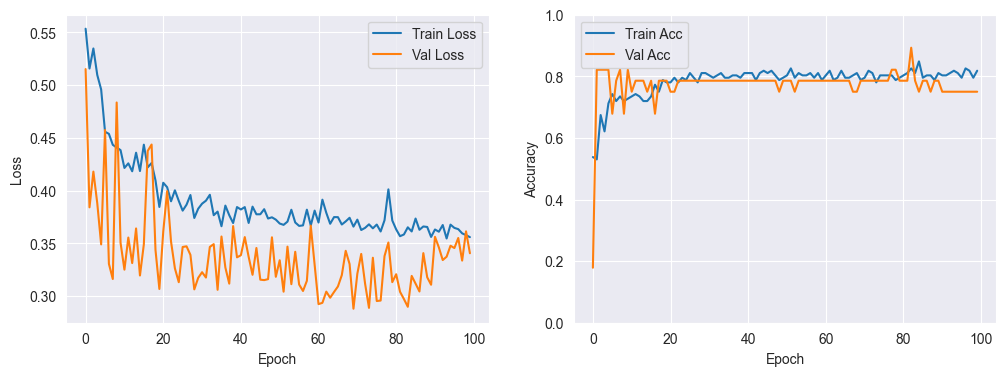

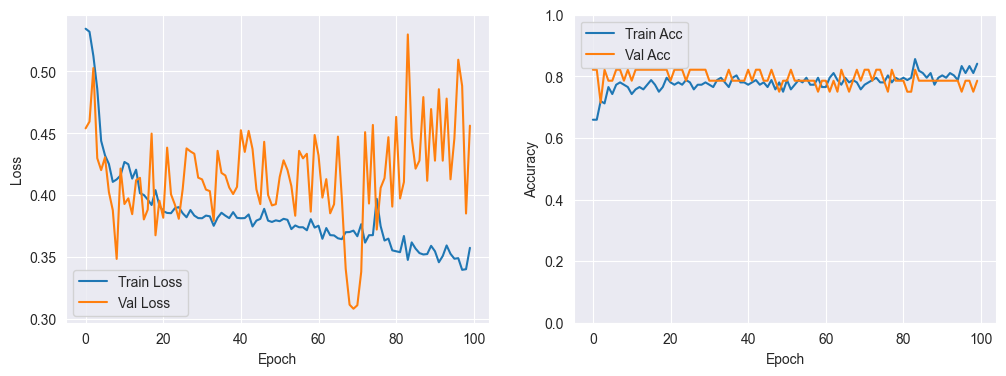

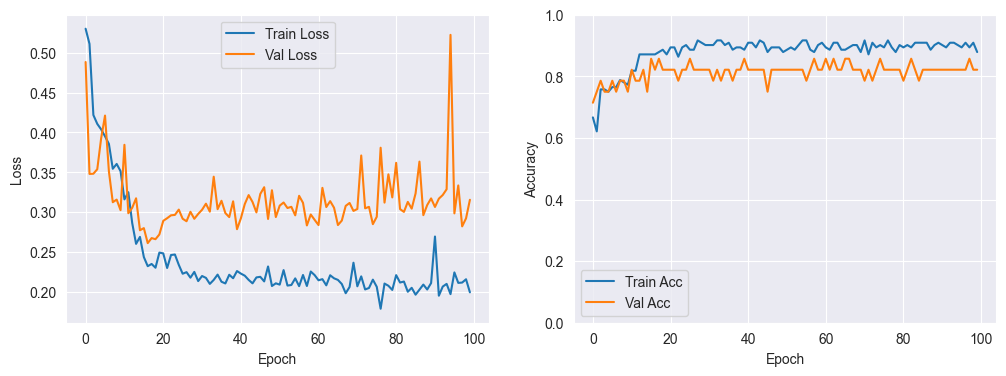

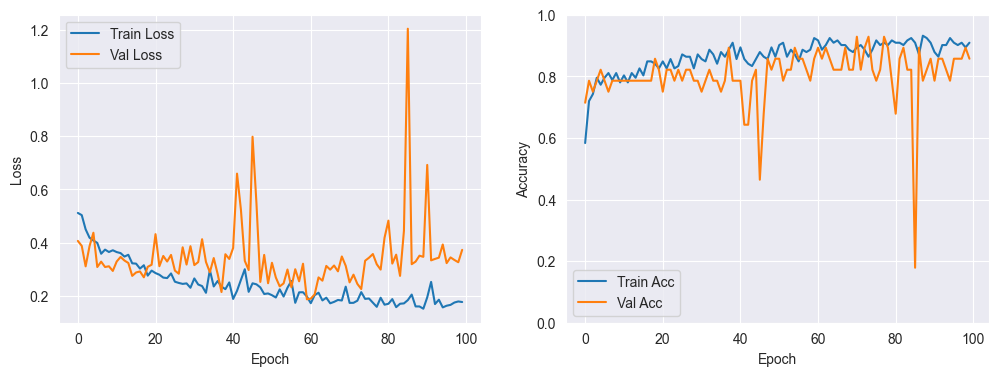

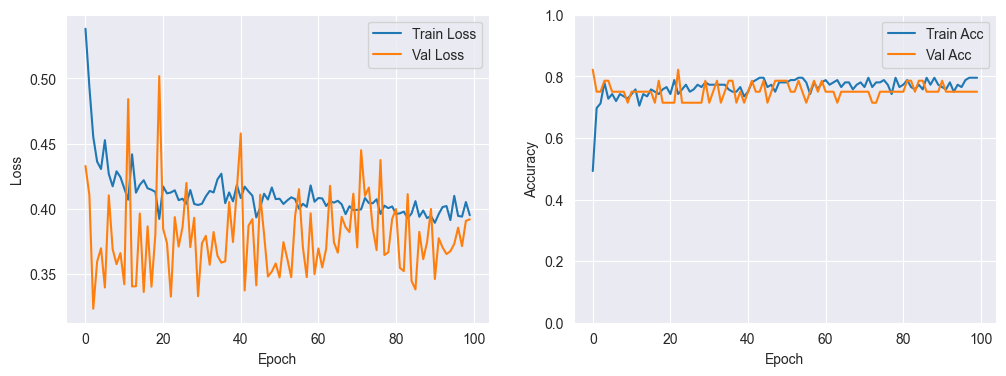

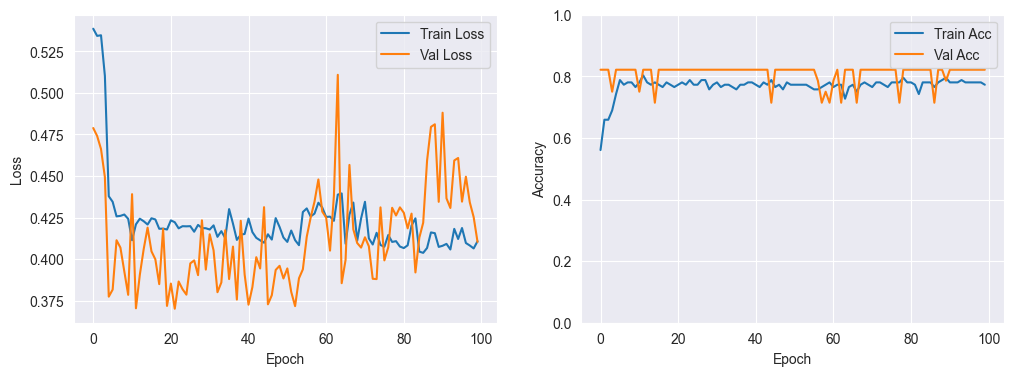

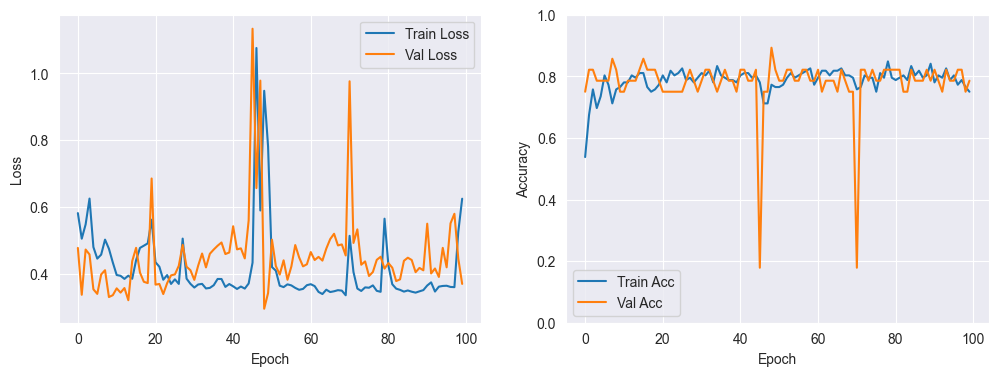

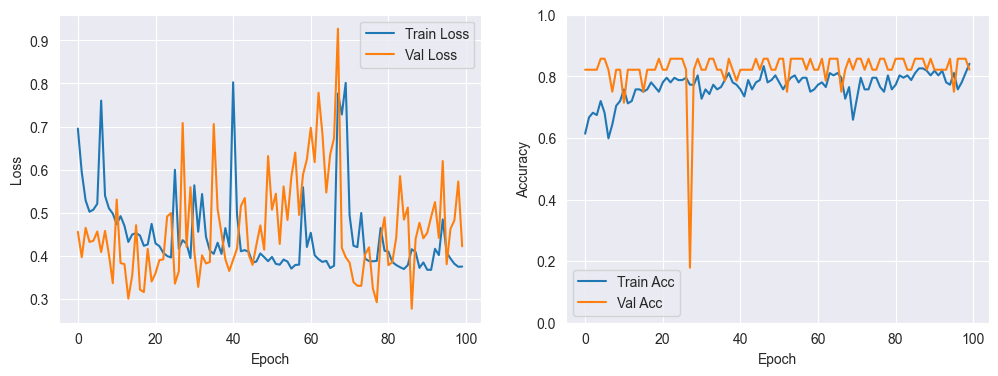

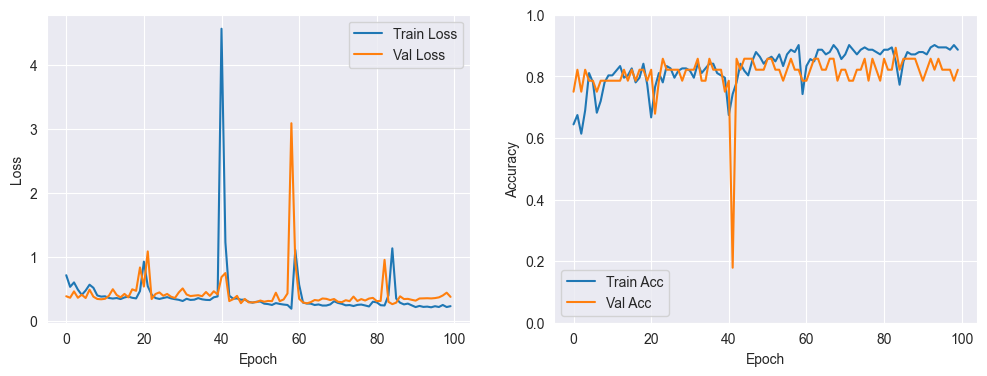

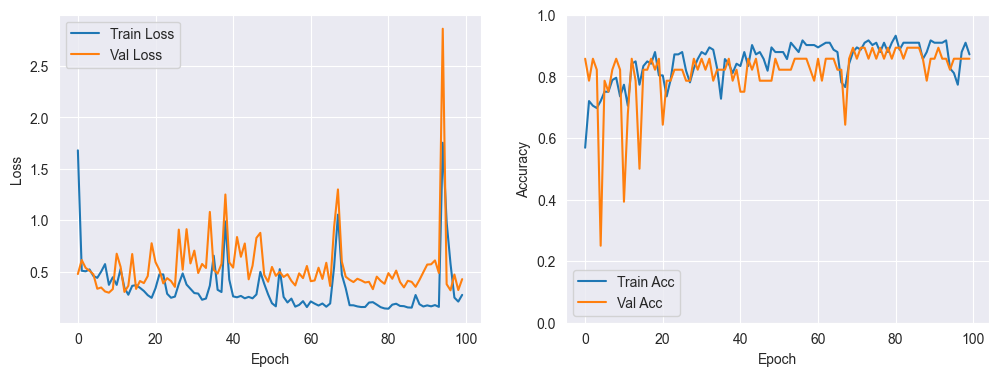

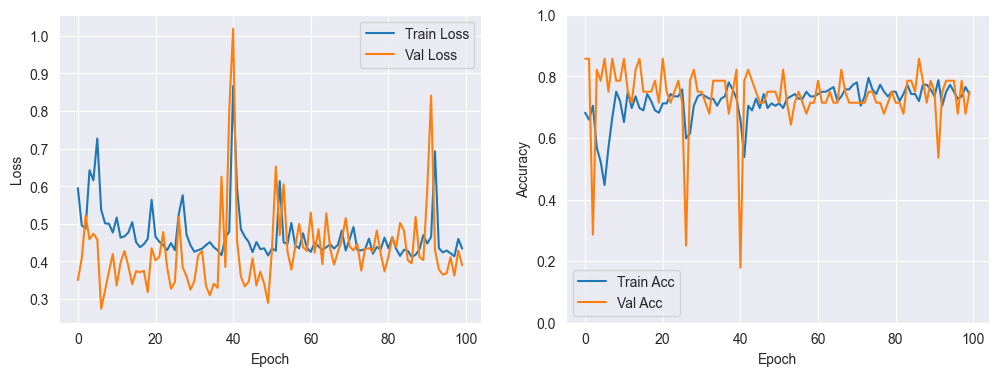

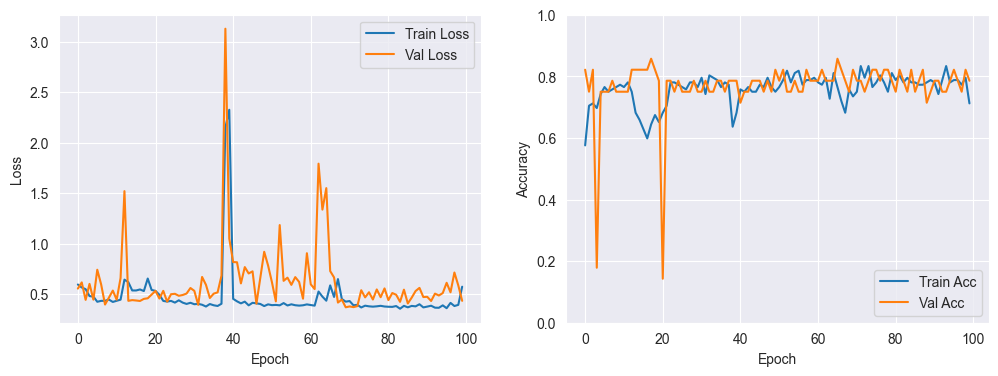

In [31]:
# Configure training hyperparameters
epochs = 100
learning_rate = 1e-2

training_results = {}
for i, model_hyperparams in enumerate(model_hyperparams_grid):
    # Initialise model and results
    model = GNN(**model_hyperparams)
    training_results[model.uuid] = TR = {}

    print(f"\nModel [{i+1}/{num_models_to_test}]")
    print(pd.Series(model_hyperparams))

    # Create unique UUID
    identifier = str(uuid.uuid4())

    # Create optimizer and loss
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([train_ratio]))

    # Train model
    start = time.time()
    train_results = train(model, train_loader, val_loader, criterion, optimiser, epochs=epochs, verbose=1)
    print(f"Training complete. ✅ ({(time.time() - start):.1f}s)")

    # Save model and training results
    TR["model"] = model
    TR["params"] = model_hyperparams
    TR["train_results"] = train_results["train_results"]
    TR["val_results"] = train_results["val_results"]

    # Create training curve
    fig = plot_training_history(train_results)

### Performance Evaluation

This section evaluates the performance of the different trained models. First, we convert the collected training results in a `pd.DataFrame` and select the model with the highest `F1` score on the validation split to get a balanced, generalising graph classification model. Next, we retrain the same model configuration on the combined training and validation split and evaluate the final performance on the test split.

In [32]:
def view_training_results(training_results, include_columns):
    """
    Utility function for putting collected training results in a multi-indexed pd.DataFrame.
    """

    # Transform dictionary
    data = {}
    for m in training_results.keys():
        data[m] = {}
        for c in training_results[m].keys():
            if c in include_columns:
                for p in training_results[m][c].keys():
                    if p in include_columns[c]:
                        data[m][(c, p)] = training_results[m][c][p]

    # Create multi-indexed dataframe
    training_results = pd.DataFrame.from_dict(data, orient="index")
    multi_indexed_columns = pd.MultiIndex.from_tuples(training_results.columns)
    training_results.columns = multi_indexed_columns

    # Sort by validation F1 score
    training_results = training_results.sort_values(by=("val_results", "f1"), ascending=False)

    # Filter columns
    include_columns = [(k, c) for k in include_columns.keys() for c in include_columns[k]]
    training_results = training_results[include_columns]

    return training_results

In [33]:
include_columns = {
    "params": ["num_features", "conv_dims", "conv", "pooling", "activation", "dropout"],
    "train_results": ["loss", "accuracy"],
    "val_results": ["loss", "accuracy", "precision", "recall", "f1"],
}

training_results_df = view_training_results(training_results, include_columns)
training_results_df

params                  \
                                 num_features       conv_dims   
10cd8a7dd32a4542a6ef003063a3a97c            7       [5, 5, 5]   
291fd7b9514849e79462f7780d634565            7  [256, 128, 64]   
44d88b2ed0484d3aaa6e4d35b8971497            7       [5, 5, 5]   
be15ad47c3ad43d3bfc12b5fa3a4b6ae            7  [256, 128, 64]   
f30ab7eb23d94639a96a9971732fe4f9            7  [256, 128, 64]   
3e09c6da9a3b4af090b76147f38c2a18            7       [5, 5, 5]   
6a8e96682dc74486b9115fcc2d93cb2d            7       [5, 5, 5]   
b8391f2520ab4781a108c9476a3a7ee5            7       [5, 5, 5]   
f5e6da6d50af401fb45c05a824fd0e22            7       [5, 5, 5]   
4b95fdc5d61a405b8545e6e97c70e60e            7  [256, 128, 64]   
e48dc2196d9c4497b50236e72f1f60e3            7  [256, 128, 64]   
b3fa8241fc9348c3943a3e47e67a182e            7  [256, 128, 64]   

                                                                          \
                                                       conv      pooling   
10cd8a7dd32a4542a6ef003063a3a97c              GraphSAGEConv   MaxPooling   
291fd7b9514849e79462f7780d634565              GraphSAGEConv   MaxPooling   
44d88b2ed0484d3aaa6e4d35b8971497              GraphSAGEConv  MeanPooling   
be15ad47c3ad43d3bfc12b5fa3a4b6ae                  GraphConv   MaxPooling   
f30ab7eb23d94639a96a9971732fe4f9              GraphSAGEConv  MeanPooling   
3e09c6da9a3b4af090b76147f38c2a18                  GraphConv   MaxPooling   
6a8e96682dc74486b9115fcc2d93cb2d  AttentionGraphConvolution   MaxPooling   
b8391f2520ab4781a108c9476a3a7ee5                  GraphConv  MeanPooling   
f5e6da6d50af401fb45c05a824fd0e22  AttentionGraphConvolution  MeanPooling   
4b95fdc5d61a405b8545e6e97c70e60e                  GraphConv  MeanPooling   
e48dc2196d9c4497b50236e72f1f60e3  AttentionGraphConvolution  MeanPooling   
b3fa8241fc9348c3943a3e47e67a182e  AttentionGraphConvolution   MaxPooling   

                                                    train_results           \
                                 activation dropout          loss accuracy   
10cd8a7dd32a4542a6ef003063a3a97c  LeakyReLU     0.0          0.18     0.91   
291fd7b9514849e79462f7780d634565  LeakyReLU     0.0          0.27     0.87   
44d88b2ed0484d3aaa6e4d35b8971497  LeakyReLU     0.0          0.20     0.88   
be15ad47c3ad43d3bfc12b5fa3a4b6ae  LeakyReLU     0.0          0.38     0.84   
f30ab7eb23d94639a96a9971732fe4f9  LeakyReLU     0.0          0.23     0.89   
3e09c6da9a3b4af090b76147f38c2a18  LeakyReLU     0.0          0.36     0.84   
6a8e96682dc74486b9115fcc2d93cb2d  LeakyReLU     0.0          0.41     0.77   
b8391f2520ab4781a108c9476a3a7ee5  LeakyReLU     0.0          0.36     0.82   
f5e6da6d50af401fb45c05a824fd0e22  LeakyReLU     0.0          0.39     0.80   
4b95fdc5d61a405b8545e6e97c70e60e  LeakyReLU     0.0          0.62     0.75   
e48dc2196d9c4497b50236e72f1f60e3  LeakyReLU     0.0          0.43     0.74   
b3fa8241fc9348c3943a3e47e67a182e  LeakyReLU     0.0          0.57     0.71   

                                 val_results                                  
                                        loss accuracy precision recall    f1  
10cd8a7dd32a4542a6ef003063a3a97c        0.37     0.86      0.78   0.91  0.81  
291fd7b9514849e79462f7780d634565        0.43     0.86      0.76   0.83  0.79  
44d88b2ed0484d3aaa6e4d35b8971497        0.32     0.82      0.72   0.81  0.75  
be15ad47c3ad43d3bfc12b5fa3a4b6ae        0.42     0.82      0.70   0.73  0.72  
f30ab7eb23d94639a96a9971732fe4f9        0.37     0.82      0.70   0.73  0.72  
3e09c6da9a3b4af090b76147f38c2a18        0.46     0.79      0.67   0.71  0.68  
6a8e96682dc74486b9115fcc2d93cb2d        0.41     0.82      0.69   0.66  0.67  
b8391f2520ab4781a108c9476a3a7ee5        0.34     0.75      0.64   0.69  0.65  
f5e6da6d50af401fb45c05a824fd0e22        0.39     0.75      0.64   0.69  0.65  
4b95fdc5d61a405b8545e6e97c70e60e        0.37     0.79      0.63   0.63  0.63  
e48dc2196d9c4497b50236

In [34]:
# Best model
best_model_idx = training_results_df[("val_results", "f1")].argmax()
best_model_info = training_results_df.iloc[best_model_idx]

best_model = training_results[best_model_info.name]["model"]

# Print best model's hyperparameters
best_model_info[["params", "val_results"]]

params       num_features                7
             conv_dims           [5, 5, 5]
             conv            GraphSAGEConv
             pooling            MaxPooling
             activation          LeakyReLU
             dropout                   0.0
val_results  loss                     0.37
             accuracy                 0.86
             precision                0.78
             recall                   0.91
             f1                       0.81
Name: 10cd8a7dd32a4542a6ef003063a3a97c, dtype: object

In [35]:
# Test best model
test_results = validate(best_model, test_loader, criterion, verbose=True)

              precision    recall  f1-score   support

         0.0       0.92      0.85      0.88        13
         1.0       0.88      0.93      0.90        15

    accuracy                           0.89        28
   macro avg       0.90      0.89      0.89        28
weighted avg       0.89      0.89      0.89        28



In [36]:
# Print numeric test results
print("Test results")
pd.Series(test_results)

Test results


loss                              0.39
accuracy                          0.89
precision                          0.9
recall                            0.89
f1                                0.89
confusion_matrix    [[11, 2], [1, 14]]
dtype: object

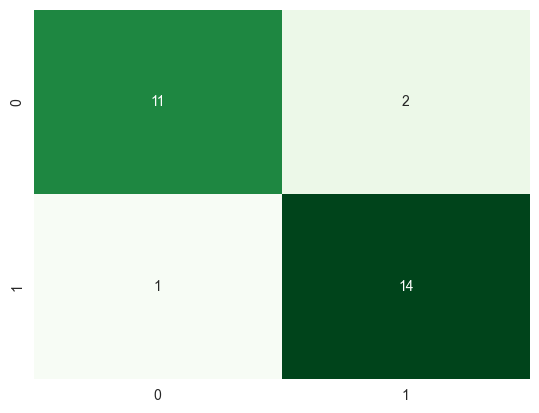

In [37]:
# Print out heatmap of confusion matrix
sns.heatmap(test_results["confusion_matrix"], annot=True, fmt="d", cmap="Greens", cbar=False);

## Part 3: Incorporating Edge Features

---


### Strategy for incorporating edge features

The approach taken in this project for including edge features in the graph classification of XY is a simplified version of the **Edge Graph Convolutional Layer**, called $\text{EGGN(C)}$ proposed in the paper [Exploiting Edge Features in Graph Neural Networks](https://arxiv.org/pdf/1809.02709.pdf), *Gong et. al*. 

In a graph $N$ nodes, we define the node feature matrix $\mathbf{H}$ as a $N \times D$ dimensional matrix and the adjancency matrix $\mathbf{A}$ as a $N \times N$ binary matrix. Now, we similarly define the edge feature matrix $\mathbf{E}$ as a $N \times N \times P$ dimensional matrix, where the entry at index $(i, j)$ represents the real-valued, $P$-dimensional edge feature vector of the edge between the $i$-th and $j$-th node. Given this notation it becomes clear that the edge feature matrix $\mathbf{E}$ can be seen as an extension of the adjacency matrix $\mathbf{A}$, where each entry is a $P$-dimensional vector instead of a scalar.

Following the method proposed in the paper and the above notation, we can extend the regular graph convolution in a straight-forward way by treating each dimension of the edge feature vector as a separate *channel* to perform graph convolution over.

$$
H^{(l+1)} = \sigma\left(\prod_{p=1}^P \tilde{E}_{\cdot\cdot p} H^{(l)} W_l \right),
$$

where $\tilde{E}_{\cdot\cdot p}$ is the $p$-th channel of the normalised edge feature matrix $\mathbf{E}$ and $W_l$ is the trainable weight matrix of the $l$-th layer.

*Note, that this is a simplified version of the method (EGNN(C)) proposed in the paper. I disregard the doubly-stochastic edge normalisation since the edge features are categorical one-hot encoded in our data and thus a regular row normalisation as done in a regular graph convolution should suffice. Further, I include the bias term, which is not done in  the paper.*

In [38]:
class EdgeGraphConv(nn.Module, metaclass=Meta):
    """Edge graph convolutional layer, adapted from the paper "Exploting Edge Features in Graph Neural Networks" (https://arxiv.org/pdf/1611.08945.pdf)."""

    def __init__(self, in_features, out_features, activation=None):
        """
        Initialize the edge graph convolutional layer.
        
        Args:
            in_features (int): number of input node features.
            out_features (int): number of output node features.
            activation (nn.Module or callable): activation function to apply. (optional)
        """
        super().__init__()
        
        # Save parameters
        self.in_features = in_features
        self.out_features = out_features

        # Linear transformation layers
        self.weight = nn.Linear(in_features, out_features, bias=False)
        self.bias = nn.Linear(in_features, out_features, bias=False)

        # Non-linear activation function (optional)
        self.activation = activation

    def forward(self, x, e):
        """
        Perform edge graph convolution operation.

        Args:
            x (Tensor): Input node features of shape (num_nodes, in_features).
            e (Tensor): Edge feature matrix of the graph, shape (num_nodes, num_nodes, num_edge_features).

        Returns:
            Tensor: Output node features after graph convolution, shape (num_nodes, out_features).
        """

        # Row normalisation of edge feature matrix
        e = e / e.sum(1, keepdim=True).clamp(1)

        # Neighborhood aggregation based on edge features
        x_agg = torch.ones((x.shape[0], self.out_features))
        for p in range(e.shape[2]):
            x_agg *= self.weight(e[:, :, p] @ x)

        # Graph convolution
        x = x_agg + self.bias(x)

        # Add non-linearity
        if self.activation:
            return self.activation(x)
        return x

In [39]:
# Test EGNN
conv = EdgeGraphConv(3, 2)
out = conv(test_x, test_e)

assert out.shape == (3, 2), f"Output shape shold be 3x2 but is {out.shape}"
assert repr(EdgeGraphConv) == "EdgeGraphConv", f"Class name should be `EdgeGraphConv`, but is {repr(EdgeGraphConv)}"

print("Tests passed. ✅")

Tests passed. ✅


### Hyperparameter Tuning



In [40]:
model_hyperparams = {
    "num_features": [7],
    "conv_dims": [[5, 5, 5], [256, 128, 64]],
    "conv": [EdgeGraphConv],
    "pooling": [MeanPooling],
    "activation": [LeakyReLU],
    "dropout": [.0],
}

model_hyperparams_grid = build_grid(model_hyperparams)
num_models_to_test = len(model_hyperparams_grid)

print(f"Testing {len(model_hyperparams_grid)} model configurations")

Testing 2 model configurations



Model [1/2]
num_features                7
conv_dims           [5, 5, 5]
conv            EdgeGraphConv
pooling           MeanPooling
activation          LeakyReLU
dropout                   0.0
dtype: object


100/100 | Train 0.4339 (70.5%) | Val 0.3538 (75.0%): 100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


Training complete. ✅ (24.4s)

Model [2/2]
num_features                 7
conv_dims       [256, 128, 64]
conv             EdgeGraphConv
pooling            MeanPooling
activation           LeakyReLU
dropout                    0.0
dtype: object


100/100 | Train 0.4395 (72.7%) | Val 0.4142 (78.6%): 100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


Training complete. ✅ (33.4s)


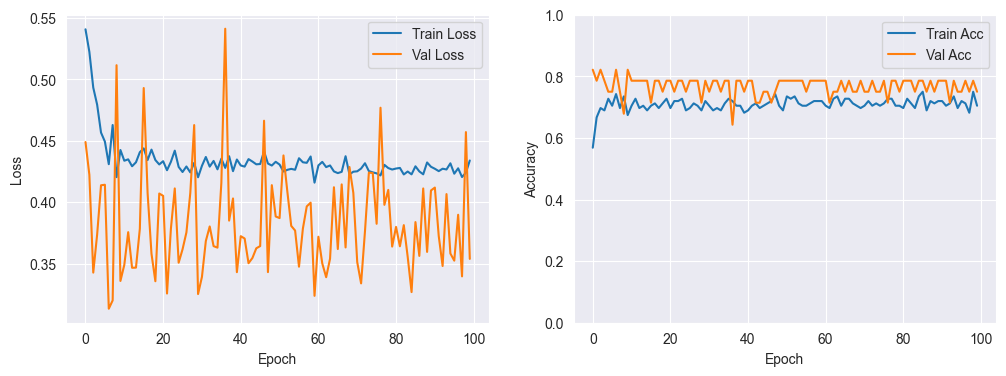

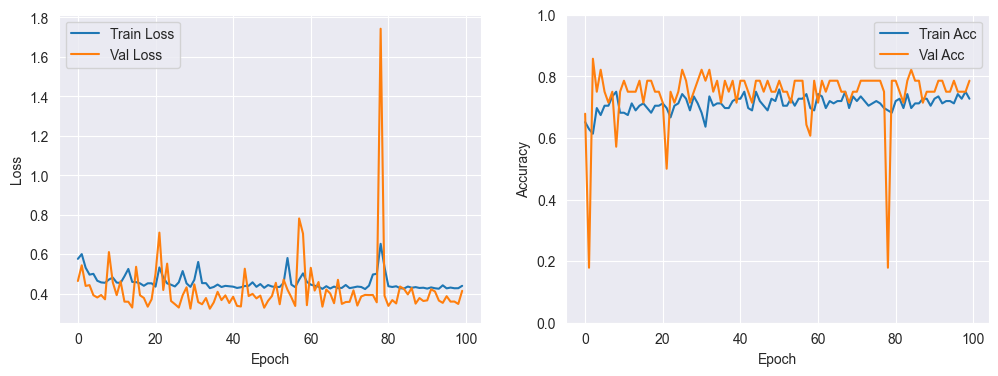

In [41]:
# Configure training hyperparameters
epochs = 100
learning_rate = 1e-2

training_results = {}
for i, model_hyperparams in enumerate(model_hyperparams_grid):
    # Initialise model and results
    model = GNN(**model_hyperparams)
    training_results[model.uuid] = TR = {}

    print(f"\nModel [{i+1}/{num_models_to_test}]")
    print(pd.Series(model_hyperparams))

    # Create unique UUID
    identifier = str(uuid.uuid4())

    # Create optimizer and loss
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([train_ratio]))

    # Train model
    start = time.time()
    train_results = train(model, train_loader, val_loader, criterion, optimiser, epochs=epochs, use_edges=True, verbose=1)
    print(f"Training complete. ✅ ({(time.time() - start):.1f}s)")

    # Save model and training results
    TR["model"] = model
    TR["params"] = model_hyperparams
    TR["train_results"] = train_results["train_results"]
    TR["val_results"] = train_results["val_results"]

    # Create training curve
    fig = plot_training_history(train_results)

### Performance Evaluation

In [42]:
training_results_df = view_training_results(training_results, include_columns)

training_results_df

params                                 \
                                 num_features       conv_dims           conv   
7aaa9e62714a4272863666d517725ce2            7  [256, 128, 64]  EdgeGraphConv   
0c8bb43adea9474ea29d6540019c3844            7       [5, 5, 5]  EdgeGraphConv   

                                                                  \
                                      pooling activation dropout   
7aaa9e62714a4272863666d517725ce2  MeanPooling  LeakyReLU     0.0   
0c8bb43adea9474ea29d6540019c3844  MeanPooling  LeakyReLU     0.0   

                                 train_results          val_results           \
                                          loss accuracy        loss accuracy   
7aaa9e62714a4272863666d517725ce2          0.44     0.73        0.41     0.79   
0c8bb43adea9474ea29d6540019c3844          0.43     0.70        0.35     0.75   

                                                         
                                 precision recall    f1  
7aaa9e62714a4272863666d517725ce2      0.70   0.79  0.71  
0c8bb43adea9474ea29d6540019c3844      0.64   0.69  0.65

In [43]:
# Best model
best_model_idx = training_results_df[("val_results", "f1")].argmax()
best_model_info = training_results_df.iloc[best_model_idx]

best_model = training_results[best_model_info.name]["model"]

# Print best model's hyperparameters
best_model_info[["params", "val_results"]]

params       num_features                 7
             conv_dims       [256, 128, 64]
             conv             EdgeGraphConv
             pooling            MeanPooling
             activation           LeakyReLU
             dropout                    0.0
val_results  loss                      0.41
             accuracy                  0.79
             precision                  0.7
             recall                    0.79
             f1                        0.71
Name: 7aaa9e62714a4272863666d517725ce2, dtype: object

In [44]:
# Test best model
test_results = validate(best_model, test_loader, criterion, use_edges=True, verbose=True)

              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62        13
         1.0       0.67      0.67      0.67        15

    accuracy                           0.64        28
   macro avg       0.64      0.64      0.64        28
weighted avg       0.64      0.64      0.64        28



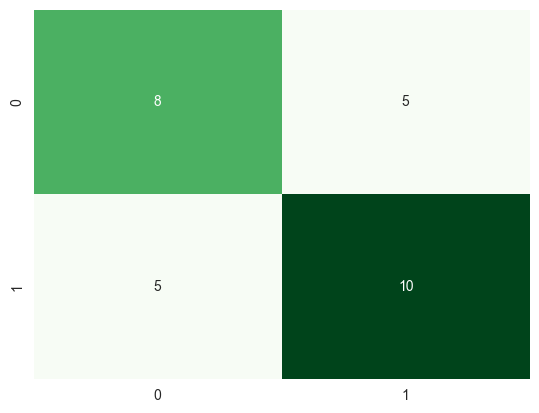

In [45]:
# Print out heatmap of confusion matrix
sns.heatmap(test_results["confusion_matrix"], annot=True, fmt="d", cmap="Greens", cbar=False);